# Ensemble_model_Kaggle_submission
## IEEE Fraud Detection (Kaggle Current Competition)


Training Part:\
train_transaction\
train_identity


Testing Part:\
test_transaction\
test_identity

Dataset can be downloaded via:\
https://www.kaggle.com/c/ieee-fraud-detection/data



In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

# Reload the testing part (20% of Traning)

The testing part is splited from training dataset, which will be used for validation.

In [81]:
train = pd.read_csv('FullData_nor_train.csv')
train.drop(columns='Unnamed: 0',inplace=True)

training, testing = train_test_split(train,test_size=0.2, random_state=42)

# Apply chi2 to do feature selection

Use Chi2 method to select top 350 features for ML prediction.

In [82]:
testing.head(2)

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,id_35_NotFound,id_35_T,id_36_NotFound,id_36_T,id_37_NotFound,id_37_T,id_38_NotFound,id_38_T,DeviceType_desktop,DeviceType_mobile
470624,0.0,0.022662,0.392389,0.762,0.381679,0.905109,0.652273,0.836957,0.011521,0.019948,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
565820,0.0,0.003389,0.663601,0.442,0.381679,0.919708,0.854545,0.836957,0.000000,0.019948,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [83]:
array = training.values
X = array[:,1:]
Y = array[:,0]

#We will select the features using chi square
chi2_selector = SelectKBest(score_func=chi2, k=350)

#Fit the function for ranking the features by score
fit = chi2_selector.fit(X, Y)
features = fit.transform(X)

In [84]:
feature_columns = [c for c in training.columns if c != 'isFraud']
new_features = []
mask = fit.get_support() #list of booleansnew_features = [] # The list of your K best features

for bool, feature in zip(mask, feature_columns):
    if bool:
        new_features.append(feature)

testing_350 = pd.DataFrame(testing[new_features], columns=new_features)
# testing_350['isFraud'] = testing['isFraud']

In [85]:
testing_350.head(2)

,card1,card3,card5,C1,C2,C4,C5,C6,C7,C8,...,id_34_match_status:2,id_35_NotFound,id_35_T,id_36_NotFound,id_37_NotFound,id_37_T,id_38_NotFound,id_38_T,DeviceType_desktop,DeviceType_mobile
470624,0.392389,0.381679,0.905109,0.000640,0.000176,0.0,0.0,0.000444,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
565820,0.663601,0.381679,0.919708,0.000427,0.000176,0.0,0.0,0.000444,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [86]:
feature_cols = [c for c in testing.columns if c != 'isFraud']
X_test_350 = testing_350.values
y_test_350 = testing['isFraud']
X_test_all = testing[feature_cols]
y_test_all = testing['isFraud']

# Reload models

In [87]:
# Loading deep_learning model
dl = load_model('weights-improvement-35-1.00.hdf5')

In [88]:
# Loading Machine_learning models
xg_boost = joblib.load('xg_class.sav')
l_gbm = joblib.load('lgbm_model.sav')
iso_forest = joblib.load('iso_model.sav')


# Predict

In [128]:
y_prob_dl = dl.predict_proba(X_test_all)
y_prob_xg = xg_boost.predict_proba(X_test_350)[:,1]
y_prob_lgbm = l_gbm.predict(X_test_350)
y_prob_iso = iso_forest.predict(X_test_350)

In [129]:

for i in range(0,len(y_prob_dl)):

    #convert into binary values
    if y_prob_dl[i] >= 0.4:
        y_prob_dl[i] = 1
    else:
        y_prob_dl[i] =0
        
    if y_prob_lgbm[i] >= 0.4:
        y_prob_lgbm[i] = 1
    else:
        y_prob_lgbm[i] =0
    
    if y_prob_xg[i] >= 0.4:
        y_prob_xg[i] = 1
    else:
        y_prob_xg[i] =0
        
    if y_prob_iso[i] == 1:
        y_prob_iso[i] = 0
    else:
        y_prob_iso[i] =1
   

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97    113866
         1.0       0.38      0.86      0.53      4242

    accuracy                           0.95    118108
   macro avg       0.69      0.90      0.75    118108
weighted avg       0.97      0.95      0.96    118108

Accuracy is 0.9452788972804552


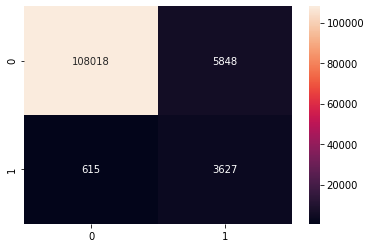

In [130]:
for i in range(0,len(y_prob_dl)):
#     print(y_prob_xg[i])
    y_pred.append((0.4*y_prob_dl[i] +0.1*y_prob_xg[i] + 0.5*y_prob_lgbm[i]+ 0*y_prob_iso[i]))
    if (y_pred[i] >= 0.4):
        y_pred[i] = 1
    else:
        y_pred[i] =0
#     print(y_pred[i])
from sklearn.metrics import accuracy_score
print(classification_report(y_test_all, y_pred))
accuracy = accuracy_score(y_pred, y_test_all)
print(f'Accuracy is {accuracy}')
cm = confusion_matrix(y_test_all, y_pred)
sns.heatmap(cm,annot=True,fmt="d");

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    113866
         1.0       0.64      0.75      0.69      4242

    accuracy                           0.98    118108
   macro avg       0.82      0.87      0.84    118108
weighted avg       0.98      0.98      0.98    118108

Accuracy is 0.9760219460155112


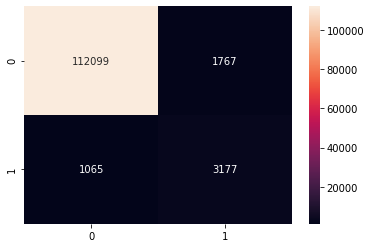

In [174]:
# Comparing with ML_LGBM:

y_pred = l_gbm.predict(X_test_350)
for i in range(0,len(y_pred)):
    #convert into binary values
    if (y_pred[i] >= 0.6):
        y_pred[i] = 1
    else:
        y_pred[i] =0
from sklearn.metrics import accuracy_score
print(classification_report(y_test_350, y_pred))
accuracy = accuracy_score(y_pred, y_test_350)
print(f'Accuracy is {accuracy}')
cm = confusion_matrix(y_test_350, y_pred)
sns.heatmap(cm,annot=True,fmt="d");

# Predict for testing dataset (Kaggle Submission)

Ranking: 3647/4014

0.7666 Accuracy with model combination.



In [131]:
test = pd.read_csv('FullData_nor_test.csv')
test.drop(columns='Unnamed: 0',inplace=True)
test.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,...,id_36_T,id_37_NotFound,id_37_T,id_38_NotFound,id_38_T,DeviceType_desktop,DeviceType_mobile,card6_debit or credit,id_34_match_status:-1,id_34_match_status:0
0,0.003109,0.540814,0.022,0.378788,0.919708,0.159091,0.836957,0.000124,0.025744,0.002034,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0
1,0.004769,0.188032,0.022,0.378788,0.919708,0.452273,0.836957,0.000495,0.025744,0.001017,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0
2,0.016649,0.199759,0.948,0.378788,0.919708,0.845455,0.836957,0.326074,0.025744,0.000678,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0
3,0.027744,0.574155,0.520,0.378788,0.481752,0.238636,0.836957,0.002104,0.025744,0.001695,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0
4,0.006615,0.978213,0.704,0.378788,0.124088,0.372727,0.836957,0.000742,0.025744,0.002034,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0


In [133]:
test_350_features = test[new_features].values
test_all_features = test.values

In [134]:
y_prob_dl = dl.predict_proba(test_all_features)
y_prob_xg = xg_boost.predict_proba(test_350_features)[:,1]
y_prob_lgbm = l_gbm.predict(test_350_features)
y_prob_iso = iso_forest.predict(test_350_features)

In [135]:
for i in range(0,len(y_prob_dl)):

    #convert into binary values
    if y_prob_dl[i] >= 0.4:
        y_prob_dl[i] = 1
    else:
        y_prob_dl[i] =0
        
    if y_prob_lgbm[i] >= 0.4:
        y_prob_lgbm[i] = 1
    else:
        y_prob_lgbm[i] =0
    
    if y_prob_xg[i] >= 0.4:
        y_prob_xg[i] = 1
    else:
        y_prob_xg[i] =0
        
    if y_prob_iso[i] == 1:
        y_prob_iso[i] = 0
    else:
        y_prob_iso[i] =1
   

In [136]:
y_pred = []
for i in range(0,len(y_prob_dl)):
#     print(y_prob_xg[i])
    y_pred.append((0.4*y_prob_dl[i] +0.1*y_prob_xg[i] + 0.5*y_prob_lgbm[i]+ 0*y_prob_iso[i]))
    if (y_pred[i] >= 0.4):
        y_pred[i] = 1
    else:
        y_pred[i] =0

In [150]:
sub_sample = pd.read_csv('sample_submission.csv')
# sub['isFraud'] = y_pred
sub_sample.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [162]:
sub.to_csv('Final_submission.csv',index=False,header=['TransactionID','isFraud'])